In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf

import tensorflow_hub as hub
import os
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers


In [2]:
# verify TensorFlow version

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
#rint("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")


Version:  2.5.0
Eager mode:  True
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is NOT AVAILABLE


### Load the data
We will download a public dataset of 54,305 images of diseased and healthy plant leaves collected under controlled conditions ( [PlantVillage Dataset](https://storage.googleapis.com/plantdata/PlantVillage.tar)). The images cover 14 species of crops, including: apple, blueberry, cherry, grape, orange, peach, pepper, potato, raspberry, soy, squash, strawberry and tomato. It contains images of 17 basic diseases, 4 bacterial diseases, 2 diseases caused by mold (oomycete), 2 viral diseases and 1 disease caused by a mite. 12 crop species also have healthy leaf images that are not visibly affected by disease. Then store the downloaded zip file to the "/tmp/" directory.

we'll  need to make sure the input data is resized to 224x224 or 229x229 pixels as required by the networks.



In [3]:
# importing required modules 
from zipfile import ZipFile 

# specifying the zip file name 
file_name = "Dataset.zip"

# opening the zip file in READ mode 
with ZipFile(file_name, 'r') as zip: 

    # extracting all the files 
    print('Extracting all the files now...') 
    zip.extractall() 



Extracting all the files now...


### Prepare training and validation  dataset
Create the training and validation directories 

In [4]:
train_dir = os.path.join('Dataset', 'train')
validation_dir = os.path.join('Dataset', 'valid')


In [5]:
import time
import os
from os.path import exists

def count(dir, counter=0):
    "returns number of files in dir and subdirs"
    for pack in os.walk(dir):
        for f in pack[2]:
            counter += 1
    return dir + " : " + str(counter) + "files"


In [6]:
print('total images for training :', count(train_dir))
print('total images for validation :', count(validation_dir))


total images for training : Dataset/train : 18653files
total images for validation : Dataset/valid : 4663files


### Label mapping

You'll also need to load in a mapping from category label to category name. You can find this in the file `categories.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/2/library/json.html). This will give you a dictionary mapping the integer encoded categories to the actual names of the plants and diseases.

In [7]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)
    classes = list(cat_to_name.values())
    
print (classes)

['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Peach___Bacterial_spot', 'Peach___healthy']


In [8]:
print('Number of classes:',len(classes))

Number of classes: 10


###Setup Image shape and  batch size

In [9]:


IMAGE_SHAPE = (380, 380)

BATCH_SIZE = 64 #@param {type:"integer"}

### Data Preprocessing

Let's set up data generators that will read pictures in our source folders, convert them to `float32` tensors, and feed them (with their labels) to our network. 

As you may already know, data that goes into neural networks should usually be normalized in some way to make it more amenable to processing by the network. (It is uncommon to feed raw pixels into a convnet.) In our case, we will preprocess our images by normalizing the pixel values to be in the `[0, 1]` range (originally all values are in the `[0, 255]` range).



In [10]:
# Inputs are suitably resized for the selected module. Dataset augmentation (i.e., random distortions of an image each time it is read) improves training, esp. when fine-tuning.

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    validation_dir, 
    shuffle=False, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)

do_data_augmentation = True #@param {type:"boolean"}
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      horizontal_flip=True,
      width_shift_range=0.2, 
      height_shift_range=0.2,
      shear_range=0.2, 
      zoom_range=0.2,
      fill_mode='nearest' )
else:
  train_datagen = validation_datagen
  
train_generator = train_datagen.flow_from_directory(
    train_dir, 
    subset="training", 
    shuffle=True, 
    seed=42,
    color_mode="rgb", 
    class_mode="categorical",
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE)


Found 4663 images belonging to 10 classes.
Found 18653 images belonging to 10 classes.


###Build the model
All it takes is to put a linear classifier on top of the feature_extractor_layer with the Hub module.

For speed, we start out with a non-trainable feature_extractor_layer, but you can also enable fine-tuning for greater accuracy.

In [11]:
model = tf.keras.Sequential([
  hub.KerasLayer("https://tfhub.dev/google/efficientnet/b0/classification/1",
                 output_shape=[1000],
                 trainable=False
                 ),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(512, activation='relu'),
  tf.keras.layers.Dropout(rate=0.2),
  tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])

### Specify Loss Function and Optimizer

In [12]:
#Compile model specifying the optimizer learning rate

LEARNING_RATE = 0.001 #@param {type:"number"}

model.compile(
   optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE), 
   loss='categorical_crossentropy',
   metrics=['accuracy'])



/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Train Model
train model using validation dataset for validate each steps

In [13]:

EPOCHS=10 #@param {type:"integer"}

history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        epochs=EPOCHS,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples//validation_generator.batch_size)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
291/291 [==============================] - 1541s 5s/step - loss: 0.3088 - accuracy: 0.8931 - val_loss: 0.1496 - val_accuracy: 0.9501
Epoch 2/10
291/291 [==============================] - 1535s 5s/step - loss: 0.1591 - accuracy: 0.9417 - val_loss: 0.0973 - val_accuracy: 0.9674
Epoch 3/10
291/291 [==============================] - 1535s 5s/step - loss: 0.1334 - accuracy: 0.9505 - val_loss: 0.1359 - val_accuracy: 0.9518
Epoch 4/10
291/291 [==============================] - 1532s 5s/step - loss: 0.1195 - accuracy: 0.9564 - val_loss: 0.1284 - val_accuracy: 0.9575
Epoch 5/10
291/291 [==============================] - 1534s 5s/step - loss: 0.1088 - accuracy: 0.9619 - val_loss: 0.1043 - val_accuracy: 0.9625
Epoch 6/10
291/291 [==============================] - 1532s 5s/step - loss: 0.1090 - accuracy: 0.9600 - val_loss: 0.0748 - val_accuracy: 0.9740
Epoch 7/10
291/291 [==============================] - 1540s 5s/step - loss: 0.1028 - accuracy: 0.9625 - val_loss: 0.0888 - val_accuracy:

###Check Performance
Plot training and validation accuracy and loss

### Random test
Random sample images from validation dataset and predict

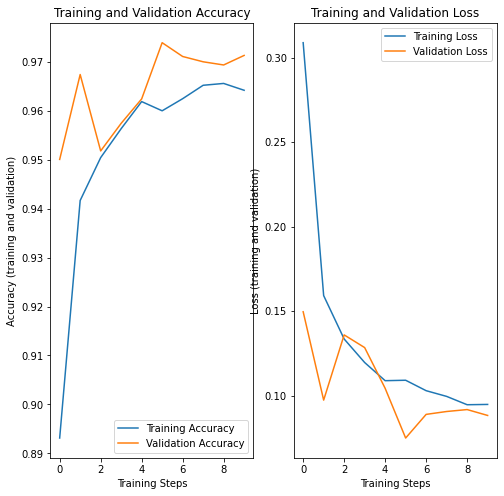

In [16]:
import matplotlib.pylab as plt
import numpy as np

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.show()

In [17]:
# Import OpenCV
import cv2

# Utility
import itertools
import random
from collections import Counter
from glob import iglob


def load_image(filename):
    img = cv2.imread(os.path.join(validation_dir, filename))
    img = cv2.resize(img, (IMAGE_SHAPE[0], IMAGE_SHAPE[1]) )
    img = img /255
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Apple___Black_rot, file: Apple___Black_rot/ab55985d-4327-44d3-ac98-17d99f4bf18d___JR_FrgE.S 2754_270deg.JPG
PREDICTED: class: Apple___Black_rot, confidence: 0.998949


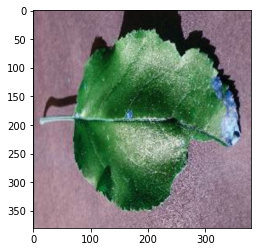

<Figure size 432x288 with 0 Axes>

SOURCE: class: Apple___Apple_scab, file: Apple___Apple_scab/4147e694-ce1f-47ea-b641-899e60ef3f3a___FREC_Scab 3278_new30degFlipLR.JPG
PREDICTED: class: Apple___Black_rot, confidence: 0.828693


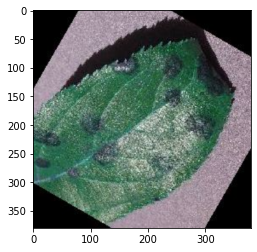

SOURCE: class: Corn_(maize)___Northern_Leaf_Blight, file: Corn_(maize)___Northern_Leaf_Blight/83327a8d-9bfd-49d6-9fc9-bc065a379bce___RS_NLB 4044 copy 2_180deg.jpg
PREDICTED: class: Corn_(maize)___Northern_Leaf_Blight, confidence: 0.897455


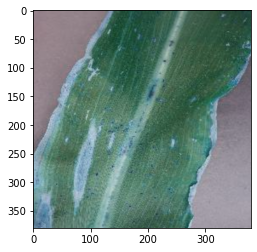

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn_(maize)___Common_rust_, file: Corn_(maize)___Common_rust_/RS_Rust 2216.JPG
PREDICTED: class: Corn_(maize)___Common_rust_, confidence: 0.999996


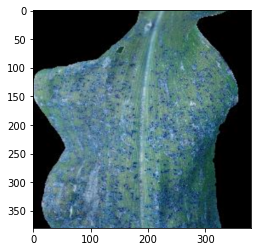

<Figure size 432x288 with 0 Axes>

SOURCE: class: Corn_(maize)___healthy, file: Corn_(maize)___healthy/600f5c3a-2156-4485-b74a-c14a16534706___R.S_HL 7958 copy.jpg
PREDICTED: class: Corn_(maize)___healthy, confidence: 1.000000


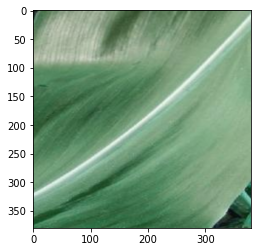

<Figure size 432x288 with 0 Axes>

In [18]:
for idx, filename in enumerate(random.sample(validation_generator.filenames, 5)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()